# Actividad 2: red CNN

### **Construye una Red Neuronal Convolucional o ResNet para clasificar imágenes de ropa en escala de grises, del dataset Fashion MNIST.**

Esta actividad es una continuación de la actividad 1: vamos a resolver la misma tarea, pero disponiendo de nuevas herramientas como las convoluciones, convoluciones traspuestas, dropout, skip connections...

El dataset FashionMNIST esta formado por imágenes del mismo tamaño y canales que las del dataset MNIST original de números escritos a mano, por lo que puede usarse gran parte del código del ejercicio resuelto MNIST_CNN como ayuda.

**Para aprobar, el código debe ejecutar sin errores importantes** (no pasa nada por algun warning leve de pytorch), la red se debe entrenar y la función de perdida disminuir. Otro requisito para aprobar es que la red, despues de entrenada, **tiene que poder clasificar de manera correcta la clase de la imagen con una precisión de al menos 30%**. Este límite esta puesto para evitar casos en los que no se haya entrenado nada y este clasificando de manera aleatoria (en ese caso la precisión sería del 10% aproximadamente). Como último requisito, **la red debe usar al menos una capa convolucional y como mínimo otro de los componentes vistos en la clase de la semana 2**, para evitar que sea igual que la red de la actividad 1.

Se valorara positivamente que de buenos resultados sin que sea una copia exacta de la red del ejercicio resuelto. No es necesario que la red sea muy grande, deberiais poder entrenarla en Google Colab en unos minutos. Si ves que tarda mucho en entrenarse, puedes probar a cambiar el entorno de ejecución de Google Colab a un entorno con GPU (en Colab en el menu que se abre arriba a la derecha, "Cambiar tipo de entorno de ejecución > T4 GPU")

Si te surgen problemas, aconsejo partir de la red del ejercicio resuelto y tocar poco a poco parámetros, para ver que efecto tienen. Si te atascas, no dudes en publicar tus dudas en el tablon para que otros alumnos o el profesor te pueda ayudar.

Añado el codigo de inicializacion de Pytorch, de carga de la base de datos FashionMNIST, y de pintar unas imagenes para comprobar que se ha cargado correctamente.

De manera opcional, para los que quieran una versión más difícil de la actividad, en lugar de usar el dataset FashionMNIST, podeis usar el dataset CIFAR10, que contiene 60000 imagenes en color de 32x32 pixeles. Este dataset esta tambien disponible en pytorch https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html

**La entrega de la actividad será el archivo del cuaderno de Jupyter (archivo .ipynb). Puede descargarse desde Archivo > Descargar > Descargar .ipynb**

In [1]:
# importamos la libreria pytorch
import torch
from torch import nn
from torch import optim #las funciones de optimizacion (gradient descent)
from torch.optim.lr_scheduler import StepLR #learning rate decay
import torch.nn.functional as F 
from torchvision import datasets, transforms,utils
from torch.utils.data import DataLoader, random_split

# matplotlib para pintar graficas
import matplotlib.pyplot as plt
import numpy as np


KeyboardInterrupt: 

In [ ]:
# usamos la GPU de mac con arquitectura ARM (mps)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [13]:
# ver el numero de ejemplos en cada clase en los datos de validacion entrenamiento y test
def class_distribution(dataset):
    targets = torch.tensor([target for _, target in dataset])
    classes, count = torch.unique(targets, return_counts=True)
    return {c.item(): f for c, f in zip(classes, count)}

class_distribution(datasets.CIFAR10(root='data', train=True, download=True))

Files already downloaded and verified


{0: tensor(5000),
 1: tensor(5000),
 2: tensor(5000),
 3: tensor(5000),
 4: tensor(5000),
 5: tensor(5000),
 6: tensor(5000),
 7: tensor(5000),
 8: tensor(5000),
 9: tensor(5000)}

In [14]:
# Definir el tamaño del batch
batch_size = 64
train_kwargs = {'batch_size': batch_size, 'shuffle': True}
test_kwargs = {'batch_size': batch_size, 'shuffle': False}

# Definir la transformación en base a la media y la desviación estandar de cada canal
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Descargar los datos de entrenamiento y test
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# Dataloader para los datos de entrenamiento y test
train_loader = DataLoader(train_data, **train_kwargs)
test_loader = DataLoader(test_data, **test_kwargs)



# Verificar que los datos se han cargado correctamente
dataiter = iter(train_loader)
for images, labels in dataiter:
    break
    
print(images.shape)
print(labels.shape)

# Clases de CIFAR10
clases = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


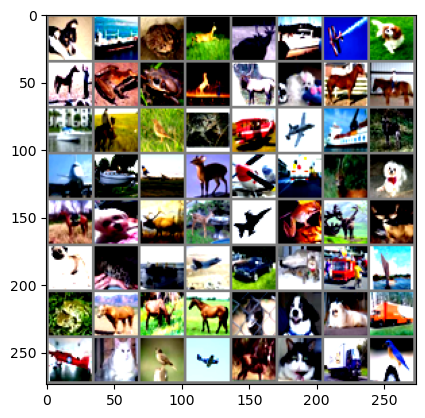

In [15]:
# mostramos unas imagenes 
def imshow(img):
    img = img / 2 + 0.5     # desnormalizamos
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# mostramos imagenes
imshow(utils.make_grid(images))


In [16]:
output_size = 10  # 10 clases en CIFAR10

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Capa convolucional 1
        self.conv1 = nn.Conv2d(in_channels=3, # 3 canales para las imágenes a color
                               out_channels=32,# 32 filtros
                               kernel_size=3,# tamaño del kernel
                               stride=1,# stride de 1 pixel
                               padding=1) # padding de 1 pixel
        # Capa de Batch Normalization 1
        self.bn1 = nn.BatchNorm2d(32)
        # Capa de Max Pooling 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        # Capa de Batch Normalization 2
        self.bn2 = nn.BatchNorm2d(64)
        # Capa de Max Pooling 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa convolucional 3
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               stride=1, 
                               padding=1)
        # Capa de Batch Normalization 3
        self.bn3 = nn.BatchNorm2d(128)
        # Capa de Max Pooling 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa convolucional 4
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        # Capa de Batch Normalization 4
        self.bn4 = nn.BatchNorm2d(256)
        # Capa de Max Pooling 4
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa de Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Capas completamente conectadas
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)  # 10 clases para CIFAR-10

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Aplanar las características para las capas completamente conectadas

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x
        

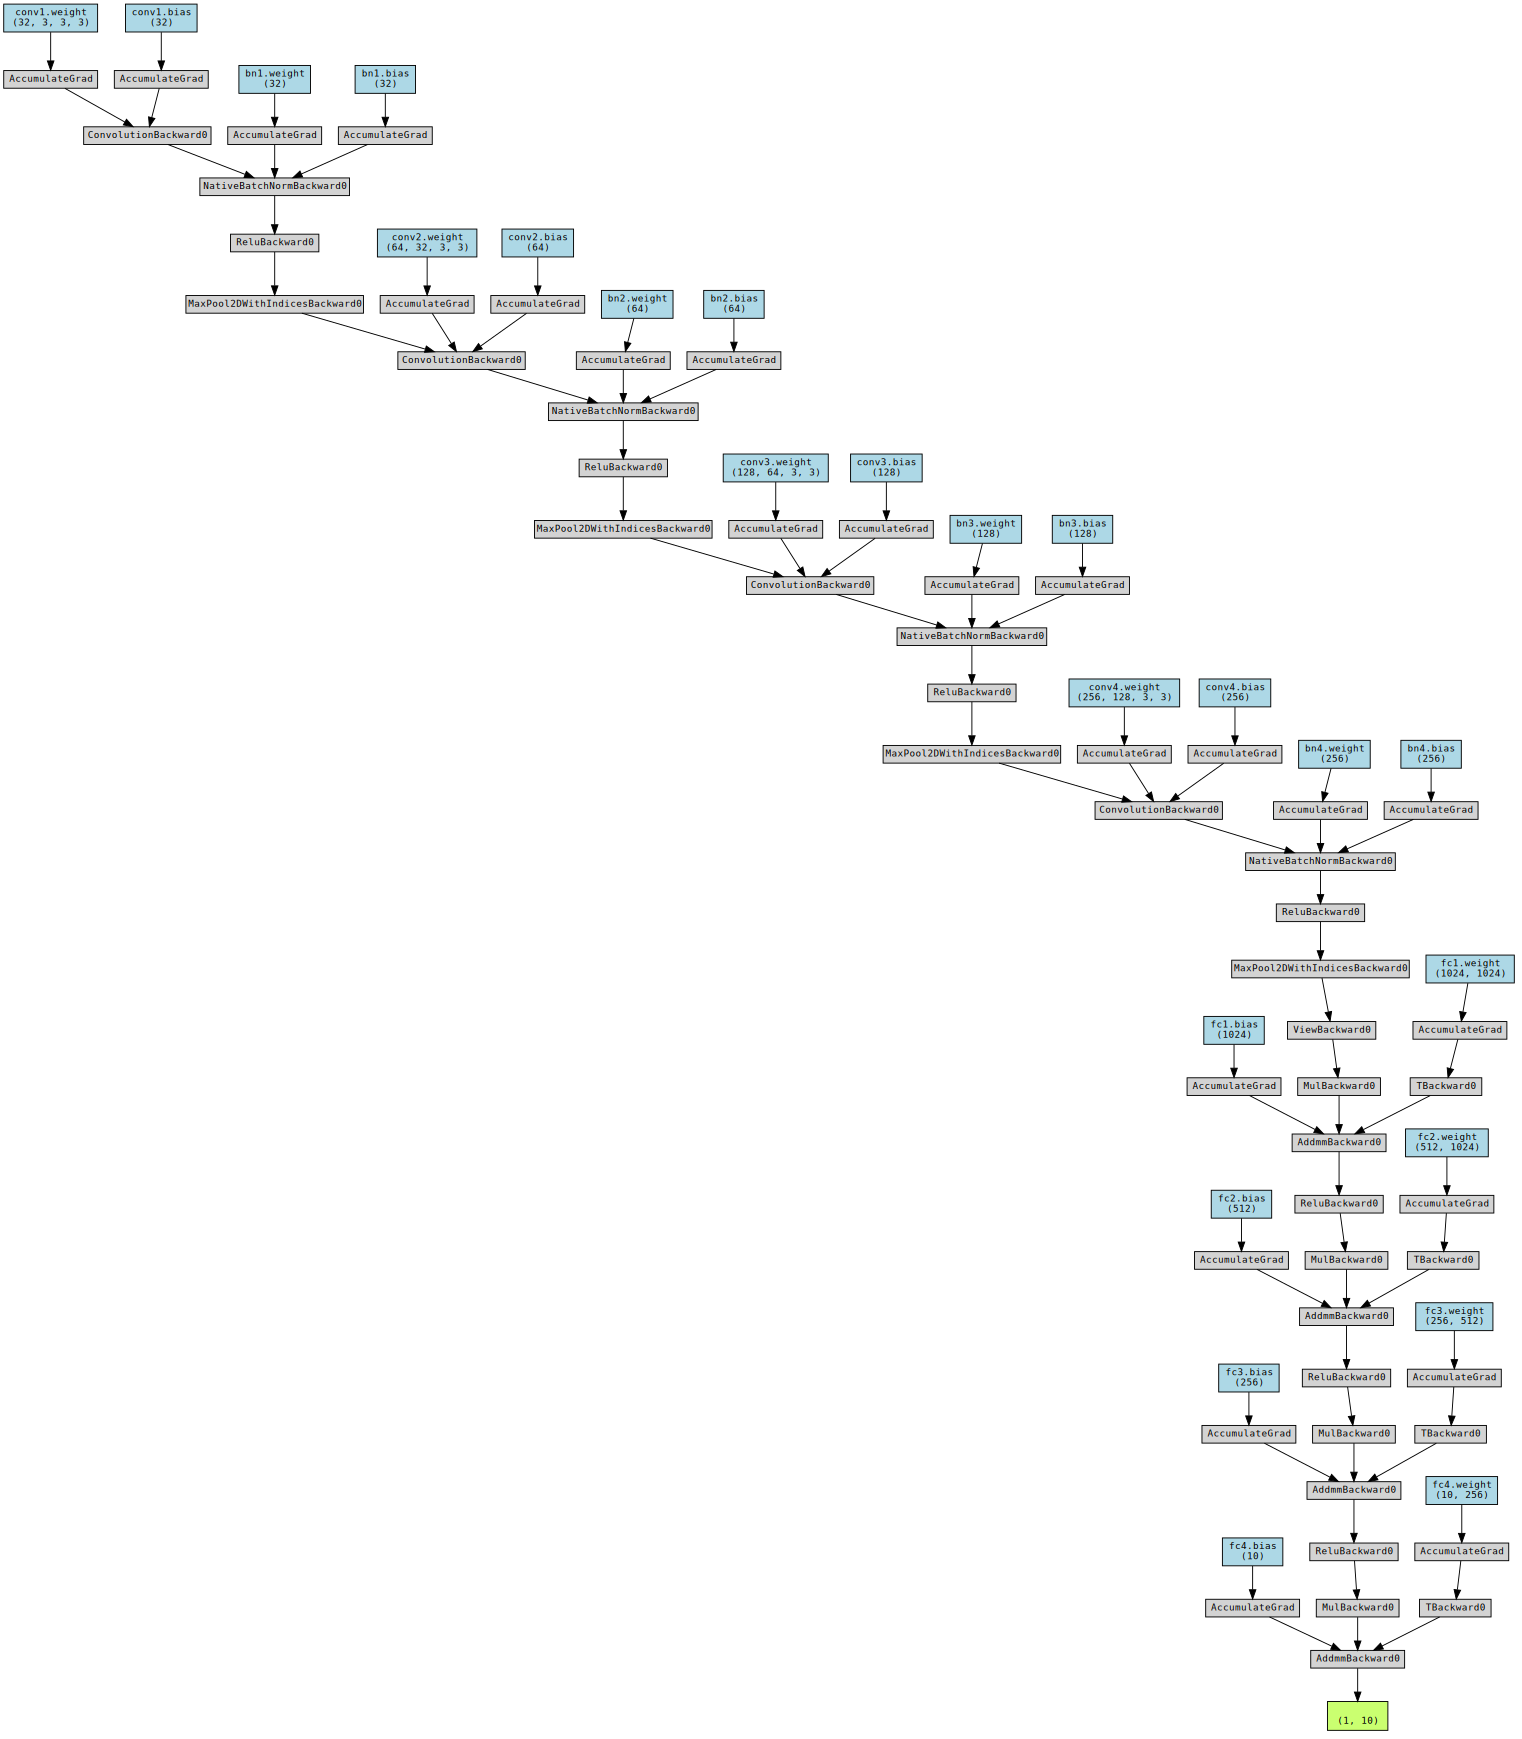

In [17]:
from torchviz import make_dot

# Asegúrate de tener tu modelo y un tensor de ejemplo listos
model = CNN()  # Asume que ya has definido e inicializado ResNet56
x = torch.randn(1, 3, 32, 32)  # Un tensor de ejemplo que coincida con la entrada del modelo

# Pasa el tensor a través del modelo para obtener el grafo de computación
y = model(x)

# Usa make_dot para crear el diagrama del grafo. Asegúrate de pasar los parámetros del modelo para mejor claridad
dot = make_dot(y, params=dict(model.named_parameters()))

# Mostrar el gráfico como salida de la celda en Jupyter Notebook
dot


In [18]:
# instanciamos la red y la movemos a la GPU (mps)
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

# Regularizacion


In [19]:
regularization = "L2 (Ridge)"

# Intensidad de la regularizacion L1
l1_weight = 0.00001

# Intensidad de la regularizacion L2
l2_weight = 0.0001

# Bucle de entrenamiento

In [20]:
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight)  # Ajustar lr a un valor más típico
epochs = 20
train_losses = []
test_losses = []
accuracy_list = []  # Lista para almacenar la precisión en cada época
scheduler = StepLR(optimizer, step_size=1, gamma=0.6)

# Entrenamiento labelizando los labels a one hot
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Movemos los tensores a la GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # convertimos los labels a one-hot
        labels_one_hot = F.one_hot(labels, output_size).float()
        
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        
        # Forward
        output = model(images)
        loss = criterion(output, labels_one_hot)
        
        # Backward
        loss.backward()
        
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Deshabilitamos el cálculo de gradientes para la validación
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                # Movemos los tensores a la GPU
                images = images.to(device)
                labels = labels.to(device)
                
                # convertimos los labels a one-hot
                labels_one_hot = F.one_hot(labels, output_size).float()
                
                # Forward
                output = model(images)
                test_loss += criterion(output, labels_one_hot)
                
                # Calculamos la precisión
                top_p, top_class = output.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        accuracy_list.append(accuracy/len(test_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
        scheduler.step()

Epoch: 1/20..  Training Loss: 0.076..  Test Loss: 0.064..  Test Accuracy: 0.509
Epoch: 2/20..  Training Loss: 0.058..  Test Loss: 0.048..  Test Accuracy: 0.648
Epoch: 3/20..  Training Loss: 0.048..  Test Loss: 0.041..  Test Accuracy: 0.719
Epoch: 4/20..  Training Loss: 0.041..  Test Loss: 0.035..  Test Accuracy: 0.759
Epoch: 5/20..  Training Loss: 0.036..  Test Loss: 0.031..  Test Accuracy: 0.784
Epoch: 6/20..  Training Loss: 0.032..  Test Loss: 0.031..  Test Accuracy: 0.787
Epoch: 7/20..  Training Loss: 0.030..  Test Loss: 0.029..  Test Accuracy: 0.797
Epoch: 8/20..  Training Loss: 0.028..  Test Loss: 0.029..  Test Accuracy: 0.803
Epoch: 9/20..  Training Loss: 0.027..  Test Loss: 0.028..  Test Accuracy: 0.801
Epoch: 10/20..  Training Loss: 0.027..  Test Loss: 0.028..  Test Accuracy: 0.801
Epoch: 11/20..  Training Loss: 0.027..  Test Loss: 0.028..  Test Accuracy: 0.805
Epoch: 12/20..  Training Loss: 0.026..  Test Loss: 0.028..  Test Accuracy: 0.802
Epoch: 13/20..  Training Loss: 0.026.

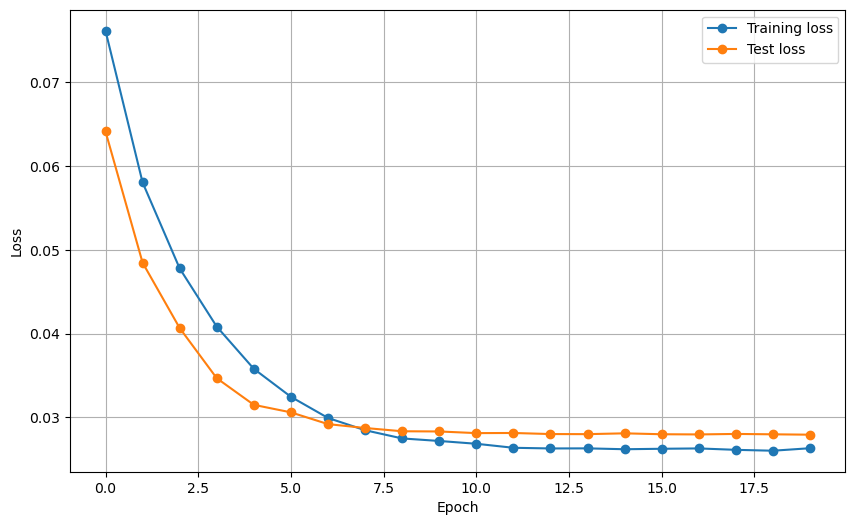

In [21]:
# Convertir listas de tensores PyTorch a arrays de NumPy
train_losses_np = np.array([loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in train_losses])
test_losses_np = np.array([loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in test_losses])

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_losses_np, label='Training loss', marker='o')
plt.plot(test_losses_np, label='Test loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


Loss: 0.0269937701523304
Accuracy: 0.8125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


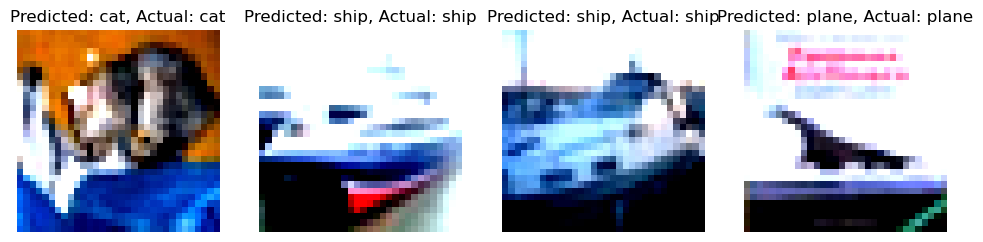

In [22]:
# Probamos el modelo con algunas imágenes de test
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

model.eval()
output = model(images)

# Calcular la pérdida
loss = criterion(output, F.one_hot(labels, output_size).float())

# Calcular la precisión
_, preds = torch.max(output, 1)
accuracy = torch.mean((preds == labels).type(torch.FloatTensor))

print('Loss:', loss.item())
print('Accuracy:', accuracy.item())

# graficamos las predicciones y las etiquetas reales
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for idx in range(4):
    ax = axes[idx]
    img = images[idx] / 2 + 0.5  # Desnormalizamos
    npimg = img.cpu().numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f'Predicted: {clases[preds[idx]]}, Actual: {clases[labels[idx]]}')
    ax.axis('off')
plt.show()

## Implementación de ResNet-56

Se ha implementado la arquitectura ResNet-56 siguiendo las especificaciones propuestas en el paper original. Esta arquitectura se caracteriza por el uso de bloques residuales, que permiten al modelo aprender funciones de identidad de manera eficiente, facilitando el entrenamiento de redes profundas sin caer en el problema de desvanecimiento o explosión de gradientes.

### Componentes clave del código:

- **ResidualBlock**: Define un bloque residual, el cual consta de dos capas convolucionales con Batch Normalization y activación ReLU. Además, incorpora una conexión de salto que puede cambiar el tamaño de la entrada si es necesario, permitiendo así la adición de la entrada original a la salida de las capas convolucionales.

- **ResNet56**: Esta clase construye la red ResNet-56, iniciando con una capa convolucional seguida por tres grupos de bloques residuales. Cada grupo de bloques aumenta el número de canales mientras reduce el tamaño espacial de las representaciones, siguiendo el patrón de diseño de las ResNets. Finalmente, se aplica un average pooling adaptativo para reducir cada mapa de características a un valor escalar, y una capa lineal transforma la salida a las clases objetivo.

### Puntos destacados:

- **Conexiones de salto**: Permiten que el gradiente fluya directamente a través de la red, lo que mejora la eficiencia del entrenamiento al mitigar el problema de desvanecimiento de gradientes.

- **Bloques residuales con cambio de tamaño**: Mediante el ajuste de la conexión de salto con una convolución 1x1 y Batch Normalization, se adapta la dimensión de las entradas para permitir la suma con la salida del bloque residual.

- **Average Pooling Adaptativo**: Se utiliza en lugar de una capa de aplanamiento para manejar de manera más flexible el tamaño de entrada de la capa lineal final, haciendo que la red sea más adaptable a diferentes tamaños de entrada.

Esta implementación de ResNet-56 está diseñada para trabajar con el conjunto de datos CIFAR-10, pero puede ser fácilmente adaptada para otras tareas de clasificación de imágenes ajustando el número de clases de salida y posiblemente el tamaño de entrada.



In [23]:
convk3 = lambda chanel_input,chanel_output,stride: nn.Conv2d(chanel_input, chanel_output,stride=stride, kernel_size=3, padding=1)

In [24]:
# Codigo de la red con RestNet56

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1,change_size=True):
        super().__init__()
        self.conv1 = convk3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = convk3(out_channels, out_channels,1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Si cambiamos el tamaño de la imagen
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(
             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
             nn.BatchNorm2d(out_channels)
                   
            )
    def forward(self, x):
        residual = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += residual
        return F.relu(y)
    
class ResNet56(nn.Module):
    
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 =convk3(3, 16, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.createBlock(n=9, 
                                       in_channels=16, 
                                       out_channels=16,
                                       stride=1,
                                       change_size=False)
        self.block2 = self.createBlock(n=9,
                                        in_channels=16,
                                        out_channels=32,
                                        stride=2,
                                        change_size=True)
        self.block3 = self.createBlock(n=9,
                                        in_channels=32,
                                        out_channels=64,
                                        stride=2,
                                        change_size=True)
        self.fc = nn.Linear(64, num_classes)
        
    def createBlock(self, n, in_channels, out_channels, stride, change_size=True):
        block = [ResidualBlock(in_channels, out_channels, stride, change_size)]
        for i in range(n-1):
            block.append(ResidualBlock(out_channels, out_channels, stride=1, change_size=False))
        return nn.Sequential(*block)
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block1(y)  
        y = self.block2(y)  
        y = self.block3(y)  
        # agregamos adaptive_avg_pool2d en vez de una capa flatten para conseguir como salida un tensor de 1x1x64 tal y como se propone en el paper
        y = F.adaptive_avg_pool2d(y, 1)
        y = y.view(y.size(0), -1)  # Aplanamos el tensor para pasarlo por la capa lineal
        return self.fc(y)

                
                        
        

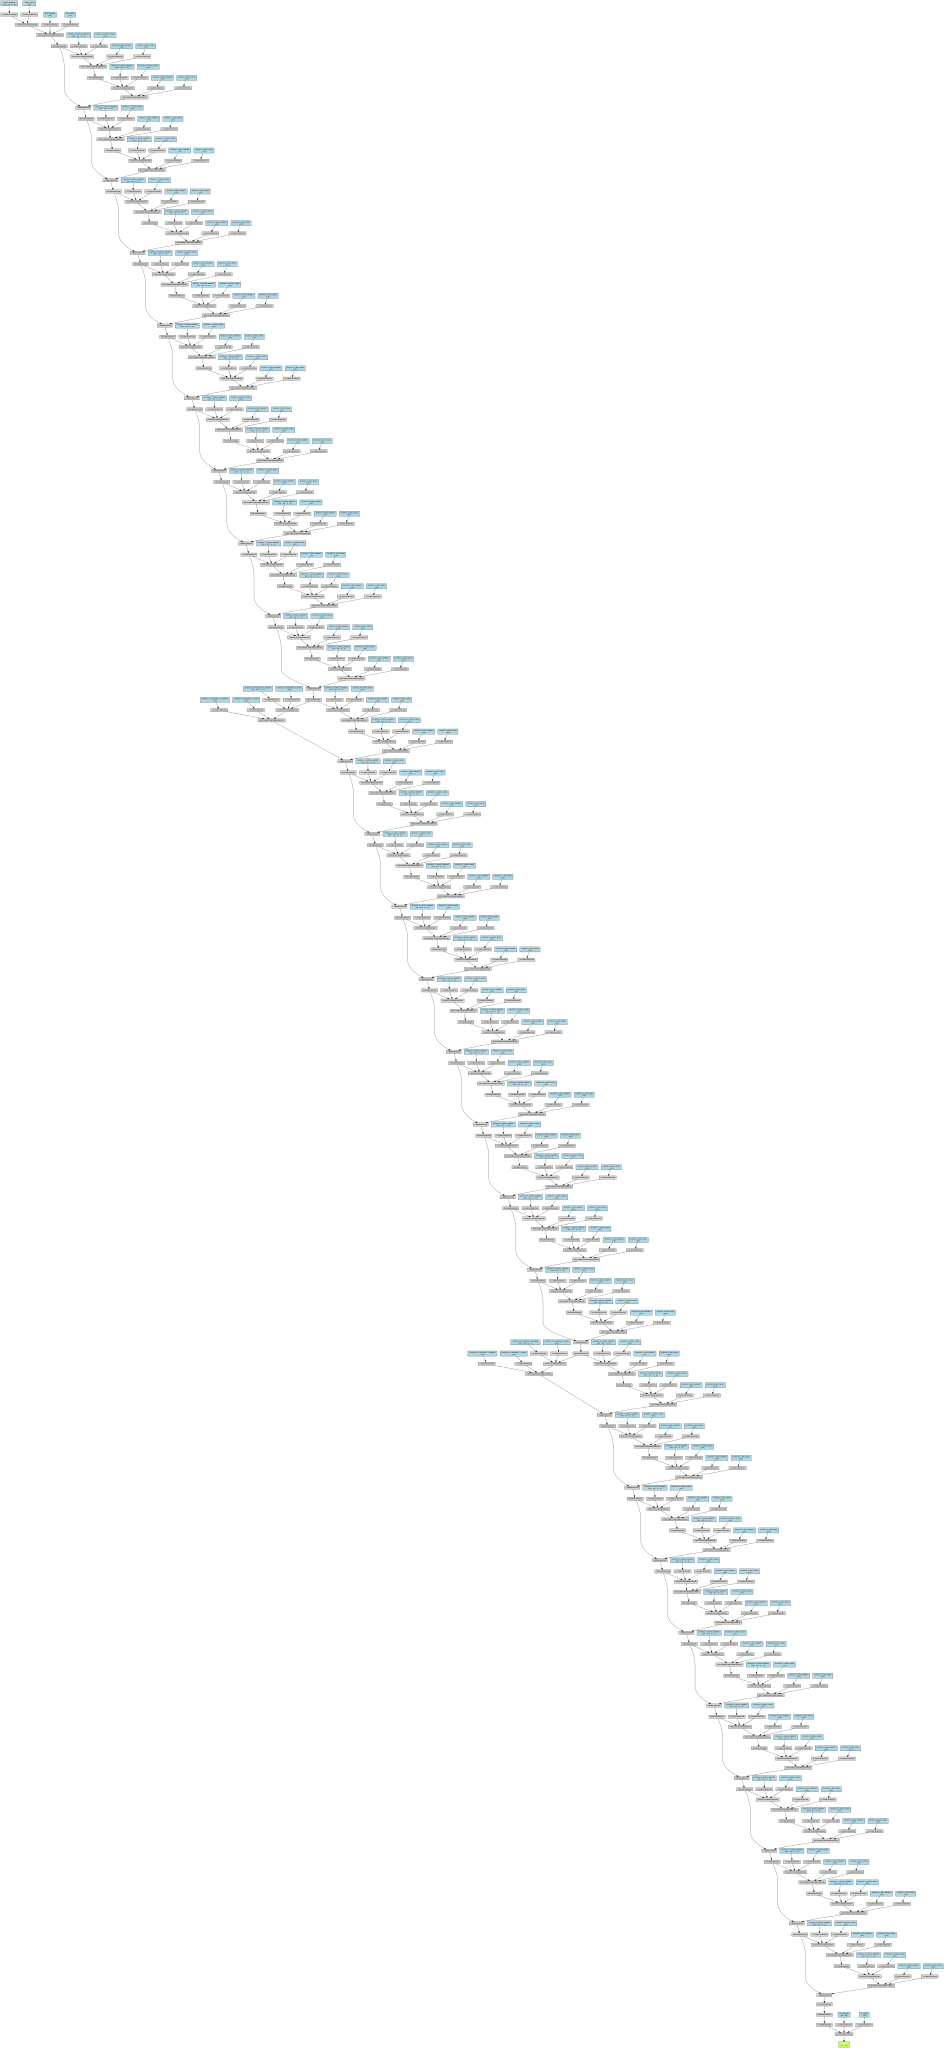

In [25]:
# Instanciamos el modelo y lo movemos a la GPU
modelRestNet = ResNet56().to(device)
x = torch.randn(1, 3, 32, 32).to(device)
y = modelRestNet(x)
dot = make_dot(y, params=dict(modelRestNet.named_parameters()))
dot

In [26]:
# funcion para buscar el lr optimo
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
        
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
        
        accuracies.append(acc_.item())
        
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

In [27]:
# en base a l gráfica determino que el lr optimo es 0.1
optomizerRestNet = optim.SGD(modelRestNet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4) # el weight_decay tal y como se propone en el paper
lr, loosses, accuracies = find_lr(modelRestNet, optomizerRestNet, start_val = 1e-6, end_val = 1) # buscamos el lr optimo haciendo un barrido de lr en un epoch

cost:2.9042, lr: 0.0000, acc: 0.1406
cost:2.8834, lr: 0.0000, acc: 0.0781
cost:2.9560, lr: 0.0000, acc: 0.1250
cost:2.7255, lr: 0.0000, acc: 0.1094
cost:2.7348, lr: 0.0000, acc: 0.1250
cost:2.9704, lr: 0.0000, acc: 0.0469
cost:2.7881, lr: 0.0000, acc: 0.1406
cost:2.9404, lr: 0.0000, acc: 0.0781
cost:2.9747, lr: 0.0000, acc: 0.0312
cost:2.7914, lr: 0.0000, acc: 0.1406
cost:3.1695, lr: 0.0000, acc: 0.0312
cost:2.9408, lr: 0.0000, acc: 0.0781
cost:2.9610, lr: 0.0000, acc: 0.0938
cost:2.8294, lr: 0.0000, acc: 0.1094
cost:2.8329, lr: 0.0000, acc: 0.0938
cost:3.1922, lr: 0.0000, acc: 0.0781
cost:2.8042, lr: 0.0000, acc: 0.1250
cost:2.6889, lr: 0.0000, acc: 0.1250
cost:2.9276, lr: 0.0000, acc: 0.0469
cost:2.8433, lr: 0.0000, acc: 0.0625
cost:2.9309, lr: 0.0000, acc: 0.0781
cost:2.7951, lr: 0.0000, acc: 0.0938
cost:2.7088, lr: 0.0000, acc: 0.1250
cost:2.8807, lr: 0.0000, acc: 0.1406
cost:2.9177, lr: 0.0000, acc: 0.1250
cost:2.9014, lr: 0.0000, acc: 0.0781
cost:2.9065, lr: 0.0000, acc: 0.0312
c

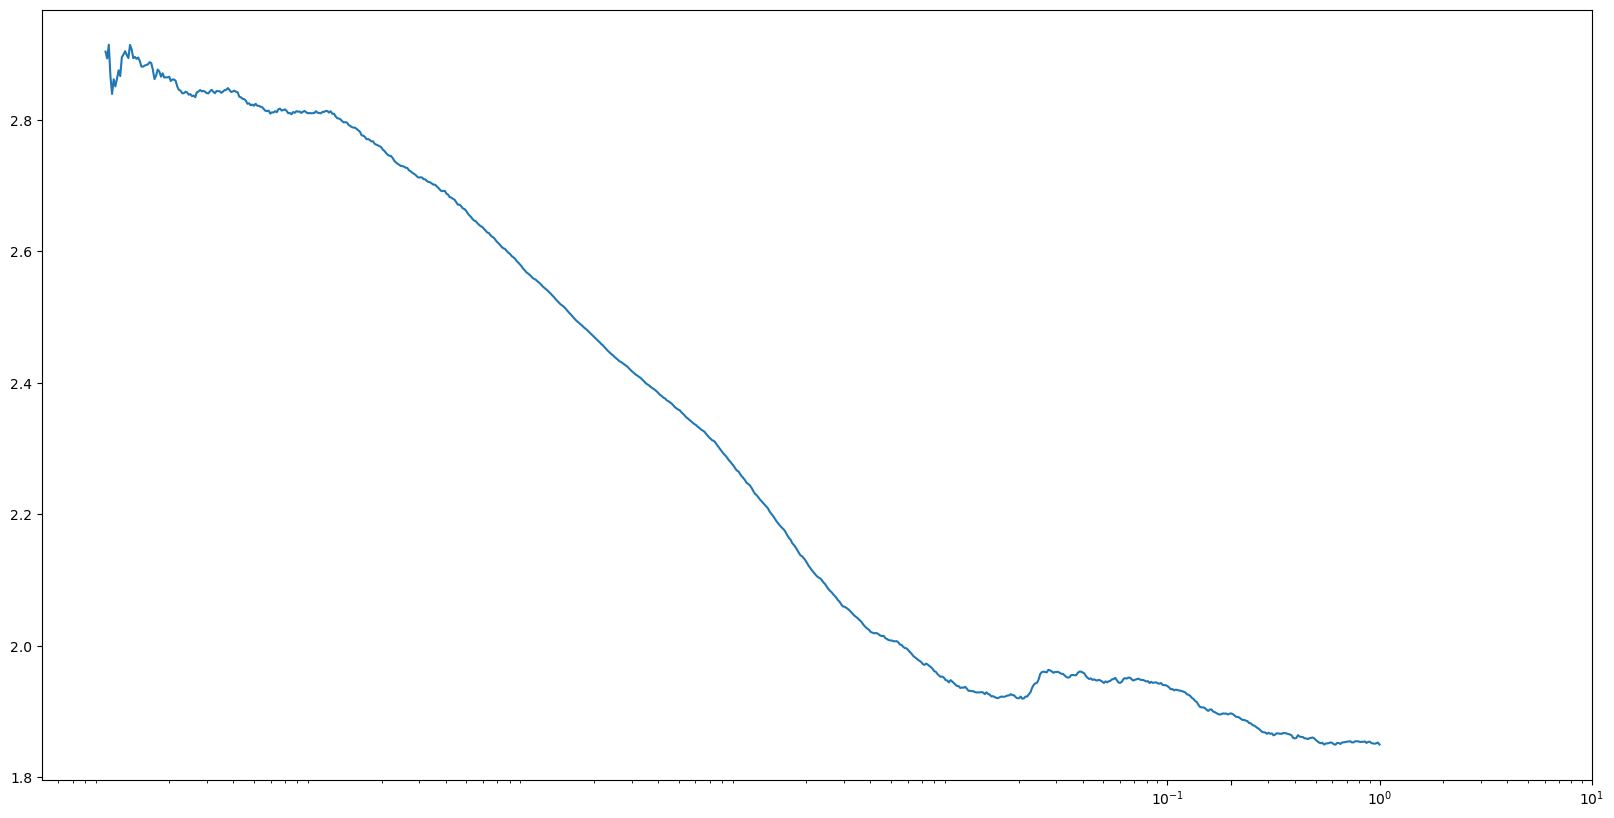

In [28]:
# graficamos la gráfica de lr vs loss
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lr, loosses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

# Bucle de entrenamiento

In [29]:
num_epochs = 20
num_classes = 10
criterion = nn.MSELoss()
loss_train = []
loss_test = []
accuracy_list = []
# optimizador
optomizerRestNet
# scheduler
scheduler = StepLR(optomizerRestNet, step_size=1, gamma=0.6)

# Entrenamiento
for epoch in range(num_epochs):
    modelRestNet.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels, num_classes).float()
        optomizerRestNet.zero_grad()
        outputs = modelRestNet(inputs)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optomizerRestNet.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            modelRestNet.eval()
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = F.one_hot(labels, num_classes).float()
                outputs = modelRestNet(inputs)
                test_loss += criterion(outputs, labels_one_hot)
                top_p, top_class = outputs.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        modelRestNet.train()
        loss_train.append(running_loss/len(train_loader))
        loss_test.append(test_loss/len(test_loader))
        accuracy_list.append(accuracy/len(test_loader))
        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        scheduler.step()


Epoch: 1/20..  Training Loss: 0.081..  Test Loss: 0.078..  Test Accuracy: 0.369
Epoch: 2/20..  Training Loss: 0.059..  Test Loss: 0.074..  Test Accuracy: 0.448
Epoch: 3/20..  Training Loss: 0.047..  Test Loss: 0.055..  Test Accuracy: 0.609
Epoch: 4/20..  Training Loss: 0.039..  Test Loss: 0.041..  Test Accuracy: 0.703
Epoch: 5/20..  Training Loss: 0.033..  Test Loss: 0.040..  Test Accuracy: 0.713
Epoch: 6/20..  Training Loss: 0.028..  Test Loss: 0.033..  Test Accuracy: 0.771
Epoch: 7/20..  Training Loss: 0.024..  Test Loss: 0.030..  Test Accuracy: 0.796
Epoch: 8/20..  Training Loss: 0.021..  Test Loss: 0.027..  Test Accuracy: 0.813
Epoch: 9/20..  Training Loss: 0.018..  Test Loss: 0.025..  Test Accuracy: 0.830
Epoch: 10/20..  Training Loss: 0.016..  Test Loss: 0.024..  Test Accuracy: 0.834
Epoch: 11/20..  Training Loss: 0.014..  Test Loss: 0.024..  Test Accuracy: 0.838
Epoch: 12/20..  Training Loss: 0.013..  Test Loss: 0.024..  Test Accuracy: 0.838
Epoch: 13/20..  Training Loss: 0.012.

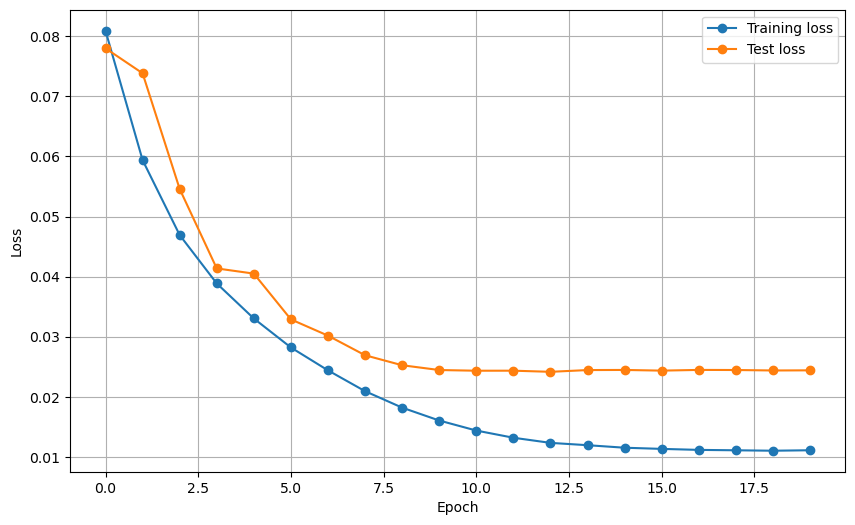

In [31]:
# graficamos la perdida de entrenamiento y test
train_losses_np = np.array([loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in loss_train])
test_losses_np = np.array([loss.cpu().detach().numpy() if hasattr(loss, 'cpu') else loss for loss in loss_test])
plt.figure(figsize=(10, 6))
plt.plot(train_losses_np, label='Training loss', marker='o')
plt.plot(test_losses_np, label='Test loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()



In [32]:
# evaluamos el modelo con algunas imagenes de test
dataiter = iter(test_loader)
images, labels = next(dataiter)
modelRestNet.eval()
images = images.to(device)
labels = labels.to(device)
output = modelRestNet(images)
loss = criterion(output, F.one_hot(labels, num_classes).float())
_, preds = torch.max(output, 1)
accuracy = torch.mean((preds == labels).type(torch.FloatTensor))
print('Loss:', loss.item())
print('Accuracy:', accuracy.item())

Loss: 0.027791177853941917
Accuracy: 0.8125
